# **BERT-based (using BERT to extract features) 电影推荐系统**
本项目使用深度神经网络，并使用[`MovieLens1M`](https://grouplens.org/datasets/movielens/)数据集完成电影推荐的任务。



## **0. 加载包**

In [1]:
! pip3 install sentence_transformers

     |████████████████████████████████| 71kB 3.2MB/s 
     |████████████████████████████████| 1.1MB 8.0MB/s 
     |████████████████████████████████| 3.0MB 38.8MB/s 
     |████████████████████████████████| 1.1MB 23.1MB/s 
     |████████████████████████████████| 890kB 37.3MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.8-cp36-none-any.whl size=101996 sha256=82877cbb533acd23575bcdef05eaa97692f5043f95779b7230309ff6b6cdbe5c
  Stored in directory: /root/.cache/pip/wheels/27/ec/b3/d12cc8e4daf77846db6543033d3a5642f204c0320b15945647
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=b80faa09ebe94c6c54005d8edf213e2c423a94848266f87471a0d72a470aebea
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [2]:
import os
import pickle
import re
import time
import datetime
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import summary_ops_v2

from sentence_transformers import SentenceTransformer, models

## **1. Data Preparing**

### 1.1 查看数据
本项目使用的是MovieLens 1M 数据集，包含6000个用户在近4000部电影上的1亿条评论。

数据集分为三个文件：用户数据users.dat，电影数据movies.dat和评分数据ratings.dat。

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
%cd '/content/drive/My Drive/Movie_lens/'

/content/drive/My Drive/Movie_lens


#### 1.1.1 用户数据
分别有用户ID、性别、年龄、职业ID和邮编等字段。

数据中的格式：UserID::Gender::Age::Occupation::Zip-code

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"



In [5]:
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


可以看出UserID、Gender、Age和Occupation都是类别字段，其中邮编字段是我们不使用的。

#### 1.1.2 电影数据
分别有电影ID、电影名和电影风格等字段。

数据中的格式：MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western


In [6]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


MovieID是类别字段，Title是文本，Genres也是类别字段

#### 1.1.3 评分数据
分别有用户ID、电影ID、评分和时间戳等字段。

数据中的格式：UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [7]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


评分字段Rating就是我们要学习的targets，时间戳字段我们不使用。

### 1.2 数据预处理

- UserID、Occupation和MovieID不用变。
- Gender字段：需要将‘F’和‘M’转换成0和1。
- Age字段：要转成7个连续数字0~6。
- Genres字段：是分类字段，使用One-hot embedding转成数字。
- Title字段：使用Sentence BERT转成句向量。

#### 1.2.1 User dataset预处理

In [8]:
#读取User数据
users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users = users.filter(regex='UserID|Gender|Age|JobID')
users_orig = users.values
#改变User数据中性别和年龄
gender_map = {'F':0, 'M':1}
users['Gender'] = users['Gender'].map(gender_map)

age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
users['Age'] = users['Age'].map(age_map)

#### 1.2.2 Movie dataset预处理

In [9]:
#读取Movie数据
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
movies_orig = movies.values

##### 1.2.2.1 Movie dataset 中Title字段处理

In [10]:
#将Title中的年份去掉
pattern = re.compile(r'^(.*)\((\d+)\)$')
title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
movies['Title'] = movies['Title'].map(title_map)

In [11]:
word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length = 16) # 定义embedding模型
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension()) # 定义pooling层
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]) # 总模型

title_encoded=model.encode(movies.Title[:]) # 对Title进行embedding

In [12]:
"""
Sentence BERT模型的原理是：
将一个句子经过BERT网络，得到每个token的embedding(768维)，对token embedding使用mean_over_time pooling得到整个句子的embedding(768维)
"""
title_encoded[0].shape

(768,)

In [13]:
#使用PCA将每个句子的embedding降到2维，可视化Sentence BERT embedding的效果
pca = PCA(n_components=2)
pca.fit(title_encoded)
print(pca.explained_variance_ratio_)

[0.11573161 0.05511457]


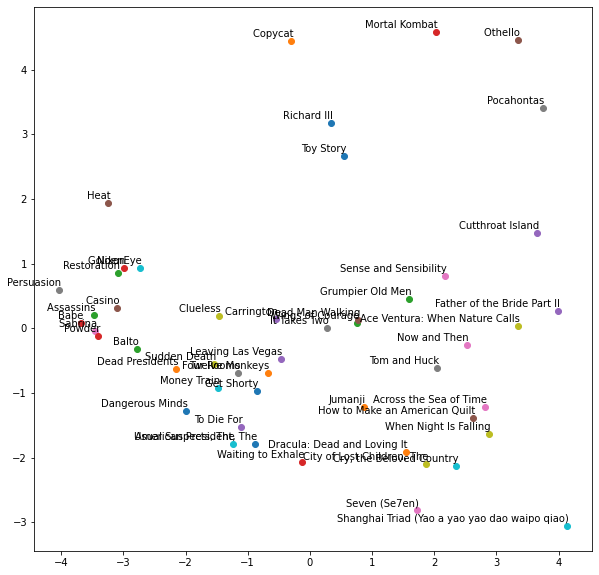

In [14]:
#可视化50个Title embedding的效果
plot_only = 50
low_dim_embs = pca.fit_transform(title_encoded[:plot_only])
labels = [movies.Title[i] for i in range(plot_only)]

plt.figure(figsize=(10, 10))
for i, label in enumerate(labels):
  x, y = low_dim_embs[i, :]
  plt.scatter(x, y)
  plt.annotate(label,xy=(x, y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')

##### 1.2.2.2 Movie dataset 中其他字段处理

In [ ]:
#电影类型one-hot编码
movies.Genres=movies.Genres.apply(lambda x: x.split('|'))
genres=[
    'Action',
    'Adventure',
    'Animation',
    "Children's",
    'Comedy',
    'Crime',
    'Documentary',
    'Drama',
    'Fantasy',
    'Film-Noir',
    'Horror',
    'Musical',
    'Mystery',
    'Romance',
    'Sci-Fi',
    'Thriller',
    'War',
    'Western'
    ]
for i in genres:
  movies[i] = movies.Genres.apply(lambda x: i in x).astype(int)

classes = movies.iloc[:,3:].values
movies['Action']=movies['Action'].astype(object)
for i in range(len(movies)):
  movies['Action'][i]=classes[i]
    
movies.drop(columns=['Genres','Adventure',
    'Animation',
    "Children's",
    'Comedy',
    'Crime',
    'Documentary',
    'Drama',
    'Fantasy',
    'Film-Noir',
    'Horror',
    'Musical',
    'Mystery',
    'Romance',
    'Sci-Fi',
    'Thriller',
    'War',
    'Western'],inplace=True)

movies = movies.rename(columns={'Action':'category'})

In [16]:
#把Title换成embedding
for i in range(len(movies)):
  movies['Title'][i] = title_encoded[i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### 1.2.3 Dataset合并

In [22]:
#读取评分数据集
ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings = ratings.filter(regex='UserID|MovieID|ratings')

#合并三个表
data = pd.merge(pd.merge(ratings, users), movies)
    
#将数据分成feature dataframe和target dataframe
target_fields = ['ratings']
features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]

#转化成numpy数组
features = features_pd.values
targets_values = targets_pd.values

#### 1.2.4 预处理后的数据一览

In [23]:
users.head()

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [24]:
movies.head()

,MovieID,Title,category
0,1,"[0.13749585, -0.10785753, -0.25206077, -0.1367...","[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[-0.097109795, -0.5188881, -0.30558717, -0.261...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,"[-0.11809706, 0.104980096, 0.08601798, 0.02849...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,4,"[0.35723495, -0.14458236, 0.15157312, -0.09572...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,"[-0.546299, -0.3512171, 0.4043779, -0.2741943,...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [25]:
data.head()

,UserID,MovieID,ratings,Gender,Age,JobID,Title,category
0,1,1193,5,0,0,10,"[0.33654428, 0.096753076, -0.31076264, -0.1392...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,1193,5,1,5,16,"[0.33654428, 0.096753076, -0.31076264, -0.1392...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,12,1193,4,1,6,12,"[0.33654428, 0.096753076, -0.31076264, -0.1392...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,15,1193,4,1,6,7,"[0.33654428, 0.096753076, -0.31076264, -0.1392...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,17,1193,5,1,3,1,"[0.33654428, 0.096753076, -0.31076264, -0.1392...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


## **2. Model Design**

### 2.1 预定义

#### 2.1.1 预定义变量

In [26]:
#嵌入矩阵的维度
embed_dim = 32
#用户ID个数
uid_max = max(features.take(0,1)) + 1  #共计6040
#性别个数
gender_max = max(features.take(2,1)) + 1  #共计2
#年龄类别个数
age_max = max(features.take(3,1)) + 1  #共计7
#职业个数
job_max = max(features.take(4,1)) + 1   #共计21
#电影ID个数
movie_id_max = max(features.take(1,1)) + 1  #共计3952
#电影Title embedding长度
sentences_size = title_count  = 768

#### 2.1.2 预定义超参

In [27]:
#Number of Epochs
num_epochs = 10

#Batch Size
batch_size = 256

#dropout
dropout_keep = 0.5

#Learning Rate
learning_rate = 0.0005

#Show stats for every n number of batches
show_every_n_batches = 20

#save path
save_dir = './save'

#### 2.1.3 预定义占位符

In [28]:
def get_inputs():
    uid = tf.keras.layers.Input(shape=(1,), dtype='int32', name='uid')  
    user_gender = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_gender')  
    user_age = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_age') 
    user_job = tf.keras.layers.Input(shape=(1,), dtype='int32', name='user_job')

    movie_id = tf.keras.layers.Input(shape=(1,), dtype='int32', name='movie_id') 
    movie_categories = tf.keras.layers.Input(shape=(18,), dtype='int32', name='movie_categories') 
    movie_titles = tf.keras.layers.Input(shape=(768,), dtype='int32', name='movie_titles') 
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles

### 2.2 构建神经网络

#### 2.2.1 定义User ID, age, job的嵌入矩阵

In [29]:
def get_user_embedding(uid, user_gender, user_age, user_job):
    uid_embed_layer = tf.keras.layers.Embedding(uid_max, embed_dim, input_length=1, name='uid_embed_layer')(uid)
    gender_embed_layer = tf.keras.layers.Embedding(gender_max, embed_dim // 2, input_length=1, name='gender_embed_layer')(user_gender)
    age_embed_layer = tf.keras.layers.Embedding(age_max, embed_dim // 2, input_length=1, name='age_embed_layer')(user_age)
    job_embed_layer = tf.keras.layers.Embedding(job_max, embed_dim // 2, input_length=1, name='job_embed_layer')(user_job)
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

#### 2.2.2将User的嵌入矩阵一起全连接生成User的特征

In [30]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    #第一层全连接
    uid_fc_layer = tf.keras.layers.Dense(embed_dim, name="uid_fc_layer", activation='relu')(uid_embed_layer)
    gender_fc_layer = tf.keras.layers.Dense(embed_dim, name="gender_fc_layer", activation='relu')(gender_embed_layer)
    age_fc_layer = tf.keras.layers.Dense(embed_dim, name="age_fc_layer", activation='relu')(age_embed_layer)
    job_fc_layer = tf.keras.layers.Dense(embed_dim, name="job_fc_layer", activation='relu')(job_embed_layer)

    #第二层全连接
    user_combine_layer = tf.keras.layers.concatenate([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
    user_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(user_combine_layer)  #(?, 1, 200)

    user_combine_layer_flat = tf.keras.layers.Reshape([200], name="user_combine_layer_flat")(user_combine_layer)
    # dropout_layer = tf.keras.layers.Dropout(dropout_keep, name = "dropout_layer")(user_combine_layer_flat)
    return user_combine_layer, user_combine_layer_flat

#### 2.2.3 定义Movie ID, genres, Title的嵌入矩阵

##### 2.2.3.1 定义Movie ID的嵌入矩阵

In [31]:
def get_movie_id_embed_layer(movie_id):
    movie_id_embed_layer = tf.keras.layers.Embedding(movie_id_max, embed_dim, input_length=1, name='movie_id_embed_layer')(movie_id)
    movie_id_embed_layer_flat = tf.keras.layers.Reshape([32], name="movie_id_embed_layer_flat")(movie_id_embed_layer)
    return movie_id_embed_layer_flat

##### 2.2.3.2 定义Movie genres的嵌入矩阵

In [32]:
def get_movie_categories_layers(movie_categories):
  movie_categories_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_categories_fc_layer", activation='relu')(movie_categories)
  return movie_categories_fc_layer

##### 2.2.3.3 定义Movie Title的嵌入矩阵

In [33]:
def get_movie_titles_layers(movie_titles):
  movie_titles_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_titles_fc_layer", activation='relu')(movie_titles)
  return movie_titles_fc_layer

#### 2.2.4 将Movie的嵌入矩阵一起全连接生成movie的特征

In [34]:
def get_movie_feature_layer(movie_id_embed_layer_flat, movie_categories_fc_layer, movie_titles_fc_layer):
    #第一层全连接
    movie_id_fc_layer = tf.keras.layers.Dense(embed_dim, name="movie_id_fc_layer", activation='relu')(movie_id_embed_layer_flat)

    #第二层全连接
    movie_combine_layer = tf.keras.layers.concatenate([movie_id_fc_layer, movie_categories_fc_layer, movie_titles_fc_layer], 1)  
    movie_combine_layer = tf.keras.layers.Dense(200, activation='tanh')(movie_combine_layer)

    movie_combine_layer_flat = tf.keras.layers.Reshape([200], name="movie_combine_layer_flat")(movie_combine_layer)
    # dropout_layer1 = tf.keras.layers.Dropout(dropout_keep, name = "dropout_layer1")(movie_combine_layer_flat)
    return movie_combine_layer, movie_combine_layer_flat

#### 2.2.5 构建Tensorflow计算图

In [35]:
MODEL_DIR = "./models"


class mv_network(object):
    def __init__(self, batch_size=256):
        self.batch_size = batch_size
        self.best_loss = 9999
        self.losses = {'train': [], 'test': []}

        # 获取输入占位符
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles = get_inputs()
        # 获取User的4个嵌入向量
        uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender, user_age, user_job)
        # 得到用户特征
        user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer)
        # 获取电影ID的嵌入向量
        movie_id_embed_layer_flat = get_movie_id_embed_layer(movie_id)
        # 获取电影种类的特征向量
        movie_categories_fc_layer = get_movie_categories_layers(movie_categories)
        # 获取电影名的特征向量
        movie_titles_fc_layer = get_movie_titles_layers(movie_titles)
        # 得到电影特征
        movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer_flat,movie_titles_fc_layer, movie_titles_fc_layer)
        
        ######## Plan 1 #########
        # 将用户特征和电影特征做矩阵乘法得到一个预测评分的方案
        inference = tf.keras.layers.Lambda(lambda layer: 
            tf.reduce_sum(layer[0] * layer[1], axis=1), name="inference")((user_combine_layer_flat, movie_combine_layer_flat))
        inference = tf.keras.layers.Lambda(lambda layer: tf.expand_dims(layer, axis=1))(inference)
        
        ######## Plan 2 #########
        # # 将用户特征和电影特征作为输入，经过全连接，输出一个值的方案
        # inference_layer = tf.keras.layers.concatenate([user_combine_layer_flat, movie_combine_layer_flat],1)  # (?, 400)
        # # 你可以使用下面这个全连接层，试试效果
        # inference_dense = tf.keras.layers.Dense(64, kernel_regularizer=tf.nn.l2_loss, activation='relu')(inference_layer)
        # inference = tf.keras.layers.Dense(1, name="inference")(inference_layer)  # inference_dense

        self.model = tf.keras.Model(
            inputs=[uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles],
            outputs=[inference])

        self.model.summary()

        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        # MSE损失，将计算值回归到评分
        self.ComputeLoss = tf.keras.losses.MeanSquaredError()
        self.ComputeMetrics = tf.keras.metrics.MeanSquaredError()

        if tf.io.gfile.exists(MODEL_DIR):
            print('Removing existing model dir: {}'.format(MODEL_DIR))
            tf.io.gfile.rmtree(MODEL_DIR)
            pass
        else:
            tf.io.gfile.makedirs(MODEL_DIR)

        train_dir = os.path.join(MODEL_DIR, 'summaries', 'train')
        test_dir = os.path.join(MODEL_DIR, 'summaries', 'eval')

        #         self.train_summary_writer = summary_ops_v2.create_file_writer(train_dir, flush_millis=10000)
        #         self.test_summary_writer = summary_ops_v2.create_file_writer(test_dir, flush_millis=10000, name='test')

        checkpoint_dir = os.path.join(MODEL_DIR, 'checkpoints')
        self.checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
        self.checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)

        # Restore variables on creation if a checkpoint exists.
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    def compute_loss(self, labels, logits):
        return tf.reduce_mean(tf.keras.losses.mse(labels, logits))

    def compute_metrics(self, labels, logits):
        return tf.keras.metrics.mse(labels, logits)  #

    @tf.function
    def train_step(self, x, y):
        # Record the operations used to compute the loss, so that the gradient
        # of the loss with respect to the variables can be computed.
        #         metrics = 0
        with tf.GradientTape() as tape:
            logits = self.model([x[0],
                                 x[1],
                                 x[2],
                                 x[3],
                                 x[4],
                                 x[5],
                                 x[6]], training=True)
            loss = self.ComputeLoss(y, logits)
            # loss = self.compute_loss(labels, logits)
            self.ComputeMetrics(y, logits)
            # metrics = self.compute_metrics(labels, logits)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, logits

    def training(self, features, targets_values, epochs=7, log_freq=50):
        train_X, test_X, train_y, test_y = train_test_split(features, targets_values, test_size=0.2, random_state=0)
        for epoch_i in range(epochs):
            # 将训练集shuffle
            state = np.random.get_state()
            np.random.shuffle(train_X)

            np.random.set_state(state)
            np.random.shuffle(train_y)

            train_batches = get_batches(train_X, train_y, self.batch_size)
            batch_num = (len(train_X) // self.batch_size)

            train_start = time.time()
            #             with self.train_summary_writer.as_default():
            if True:
                start = time.time()
                # Metrics are stateful. They accumulate values and return a cumulative
                # result when you call .result(). Clear accumulated values with .reset_states()
                avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
                #                 avg_mae = tf.keras.metrics.Mean('mae', dtype=tf.float32)

                # Datasets can be iterated over like any other Python iterable.
                for batch_i in range(batch_num):
                    x, y = next(train_batches)
                    categories = np.zeros([self.batch_size, 18])
                    for i in range(self.batch_size):
                        categories[i] = x.take(6, 1)[i]

                    titles = np.zeros([self.batch_size, sentences_size])
                    for i in range(self.batch_size):
                        titles[i] = x.take(5, 1)[i]

                    loss, logits = self.train_step([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                                    np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                                    categories.astype(np.float32),
                                                    titles.astype(np.float32)],
                                                   np.reshape(y, [self.batch_size, 1]).astype(np.float32))
                    avg_loss(loss)
                    self.losses['train'].append(loss)

                    if tf.equal(self.optimizer.iterations % log_freq, 0):
                        #                         summary_ops_v2.scalar('loss', avg_loss.result(), step=self.optimizer.iterations)
                        #                         summary_ops_v2.scalar('mae', self.ComputeMetrics.result(), step=self.optimizer.iterations)
                        # summary_ops_v2.scalar('mae', avg_mae.result(), step=self.optimizer.iterations)

                        rate = log_freq / (time.time() - start)
                        print('Step #{}\tEpoch {:>3} Batch {:>4}/{}   Loss: {:0.6f} mse: {:0.6f} ({} steps/sec)'.format(
                            self.optimizer.iterations.numpy(),
                            epoch_i,
                            batch_i,
                            batch_num,
                            loss, (self.ComputeMetrics.result()), rate))
                        # print('Step #{}\tLoss: {:0.6f} mae: {:0.6f} ({} steps/sec)'.format(
                        #     self.optimizer.iterations.numpy(), loss, (avg_mae.result()), rate))
                        avg_loss.reset_states()
                        self.ComputeMetrics.reset_states()
                        # avg_mae.reset_states()
                        start = time.time()

            train_end = time.time()
            print(
                '\nTrain time for epoch #{} ({} total steps): {}'.format(epoch_i + 1, self.optimizer.iterations.numpy(),
                                                                         train_end - train_start))
            #             with self.test_summary_writer.as_default():
            self.testing((test_X, test_y), self.optimizer.iterations)
            # self.checkpoint.save(self.checkpoint_prefix)
        self.export_path = os.path.join(MODEL_DIR, 'export')
        tf.saved_model.save(self.model, self.export_path)

    def testing(self, test_dataset, step_num):
        test_X, test_y = test_dataset
        test_batches = get_batches(test_X, test_y, self.batch_size)

        """Perform an evaluation of `model` on the examples from `dataset`."""
        avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
        #         avg_mae = tf.keras.metrics.Mean('mae', dtype=tf.float32)

        batch_num = (len(test_X) // self.batch_size)
        for batch_i in range(batch_num):
            x, y = next(test_batches)
            categories = np.zeros([self.batch_size, 18])
            for i in range(self.batch_size):
                categories[i] = x.take(6, 1)[i]

            titles = np.zeros([self.batch_size, sentences_size])
            for i in range(self.batch_size):
                titles[i] = x.take(5, 1)[i]

            logits = self.model([np.reshape(x.take(0, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(2, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(3, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(4, 1), [self.batch_size, 1]).astype(np.float32),
                                 np.reshape(x.take(1, 1), [self.batch_size, 1]).astype(np.float32),
                                 categories.astype(np.float32),
                                 titles.astype(np.float32)], training=False)
            test_loss = self.ComputeLoss(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            avg_loss(test_loss)
            # 保存测试损失
            self.losses['test'].append(test_loss)
            self.ComputeMetrics(np.reshape(y, [self.batch_size, 1]).astype(np.float32), logits)
            # avg_loss(self.compute_loss(labels, logits))
            # avg_mae(self.compute_metrics(labels, logits))

        print('Model test set loss: {:0.6f} mse: {:0.6f}'.format(avg_loss.result(), self.ComputeMetrics.result()))
        # print('Model test set loss: {:0.6f} mae: {:0.6f}'.format(avg_loss.result(), avg_mae.result()))
        #         summary_ops_v2.scalar('loss', avg_loss.result(), step=step_num)
        #         summary_ops_v2.scalar('mae', self.ComputeMetrics.result(), step=step_num)
        # summary_ops_v2.scalar('mae', avg_mae.result(), step=step_num)

        if avg_loss.result() < self.best_loss:
            self.best_loss = avg_loss.result()
            print("best loss = {}".format(self.best_loss))
            self.checkpoint.save(self.checkpoint_prefix)

    def forward(self, xs):
        predictions = self.model(xs)
        # logits = tf.nn.softmax(predictions)

        return predictions

In [36]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

### 2.3 训练神经网络

In [37]:
mv_net=mv_network()
mv_net.training(features, targets_values, epochs=7)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
uid (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_gender (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_age (InputLayer)           [(None, 1)]          0                                            
_______________________________________________________________________________________

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./models/export/assets


INFO:tensorflow:Assets written to: ./models/export/assets


### 2.4 可视化模型的训练结果

#### 2.4.1 显示训练Loss

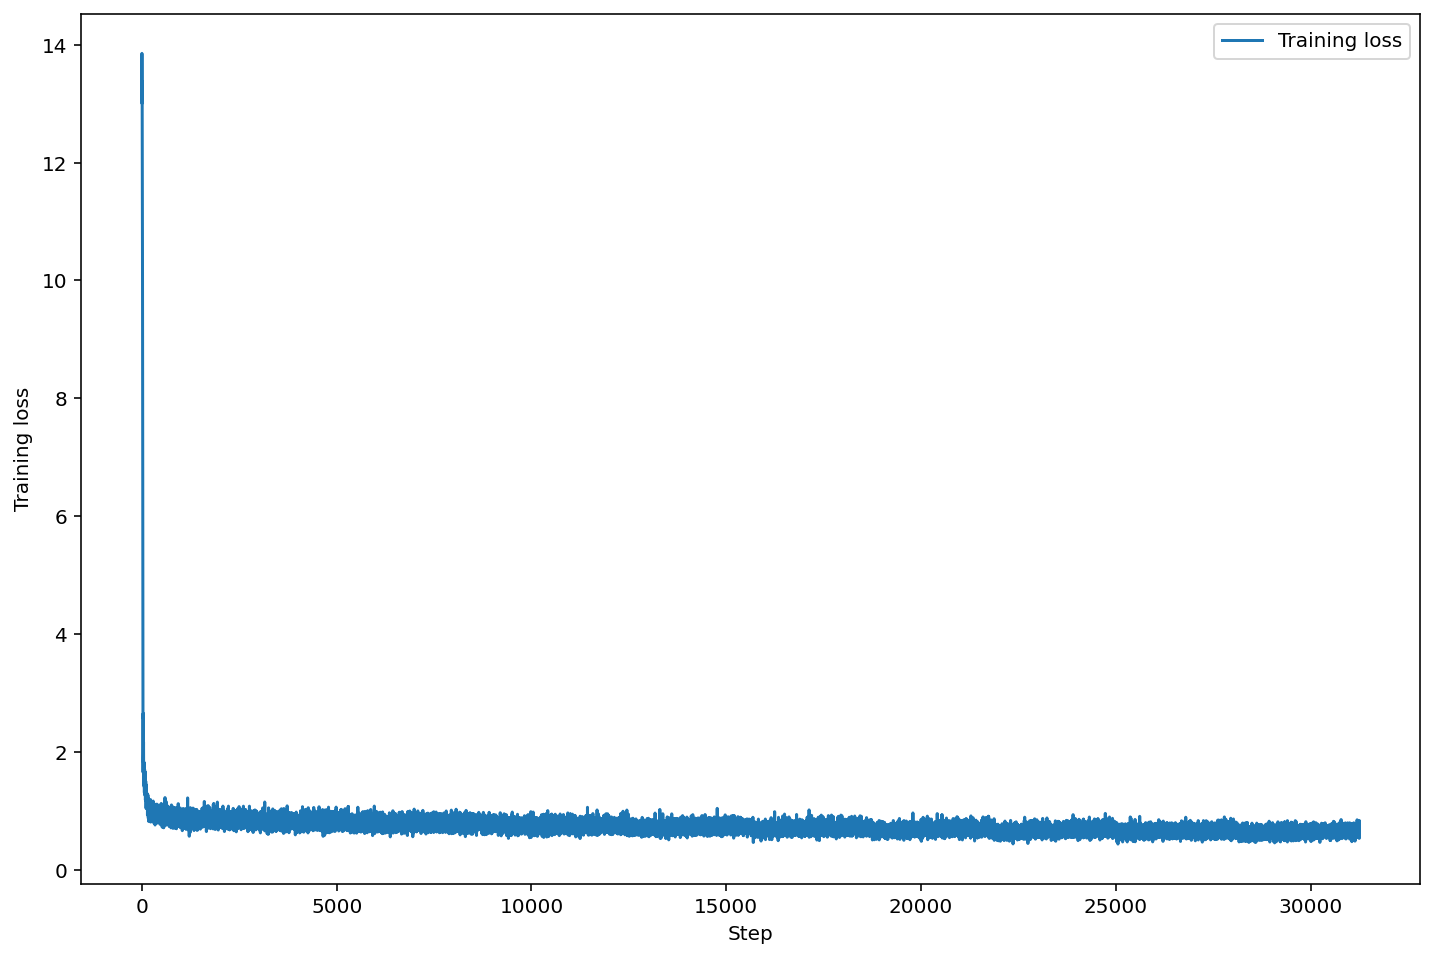

In [38]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12,8))
plt.plot(mv_net.losses['train'], label='Training loss')
plt.xlabel('Step')
plt.ylabel('Training loss')
plt.legend()
_ = plt.ylim()

#### 2.4.2 显示测试Loss

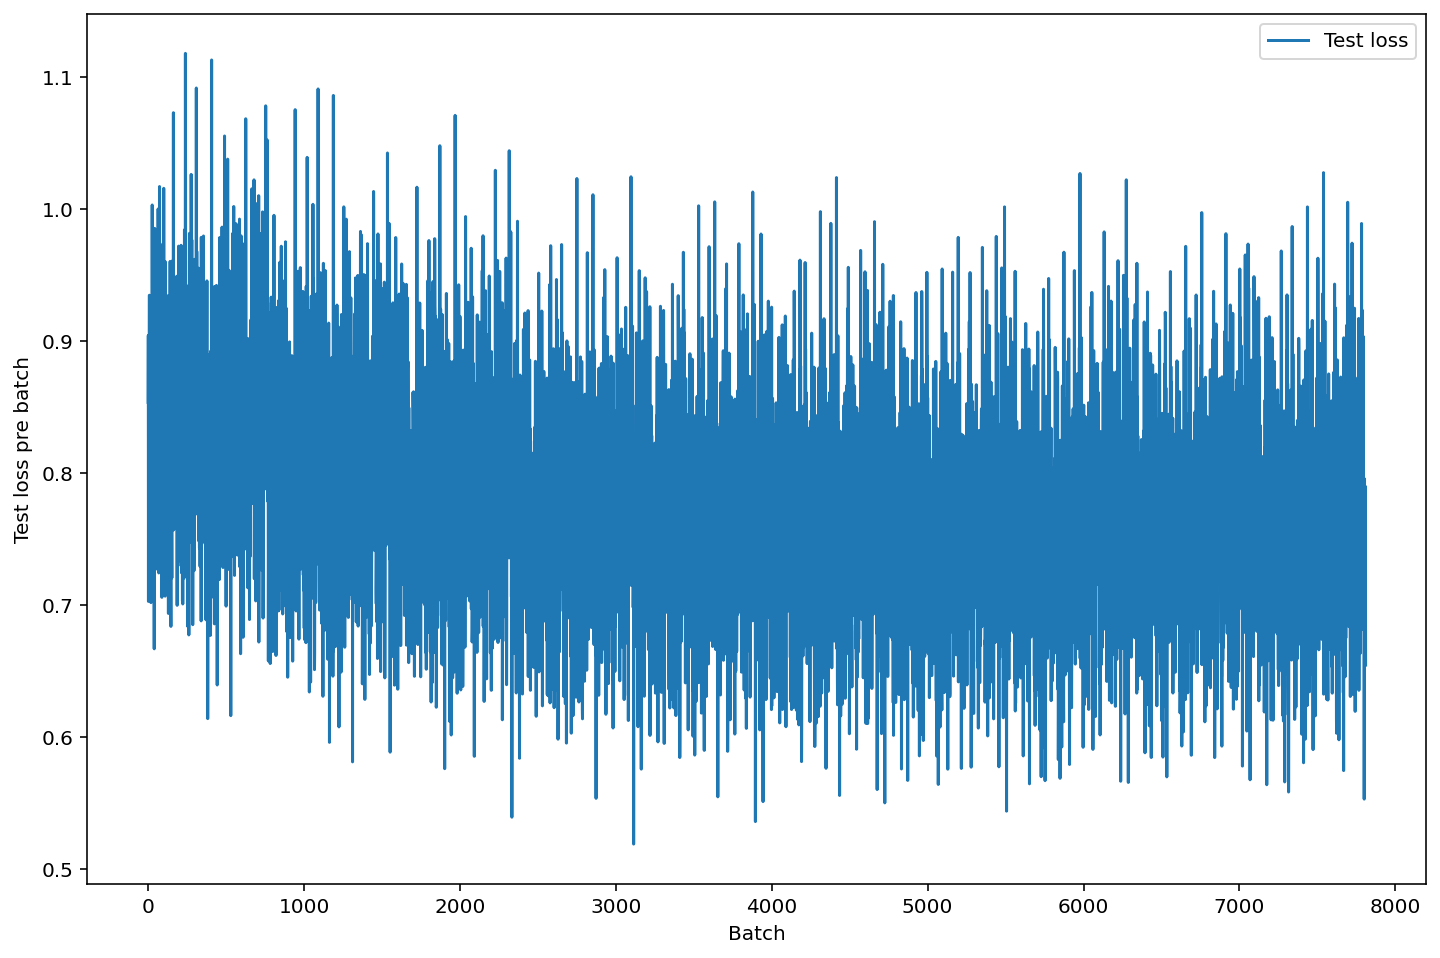

In [39]:
plt.figure(figsize=(12,8))
plt.plot(mv_net.losses['test'], label='Test loss')
plt.xlabel('Batch')
plt.ylabel('Test loss pre batch')
plt.legend()
_ = plt.ylim()

## **3. 利用模型进行电影推荐**

### 3.1 生成Movie特征矩阵
将训练好的电影特征组合成电影特征矩阵并保存到本地

In [40]:
movie_layer_model = keras.models.Model(inputs=[mv_net.model.input[4], mv_net.model.input[5], mv_net.model.input[6]], 
                                 outputs=mv_net.model.get_layer("movie_combine_layer_flat").output)
movie_matrics = []

for item in movies.values:
    categories = np.zeros([1, 18])
    categories[0] = item.take(2)

    titles = np.zeros([1, sentences_size])
    titles[0] = item.take(1)

    movie_combine_layer_flat_val = movie_layer_model([np.reshape(item.take(0), [1, 1]), categories, titles])  
    movie_matrics.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

### 3.2 生成User特征矩阵
将训练好的用户特征组合成用户特征矩阵并保存到本地

In [41]:
user_layer_model = keras.models.Model(inputs=[mv_net.model.input[0], mv_net.model.input[1], mv_net.model.input[2], mv_net.model.input[3]], 
                                 outputs=mv_net.model.get_layer("user_combine_layer_flat").output)
users_matrics = []

for item in users.values:

    user_combine_layer_flat_val = user_layer_model([np.reshape(item.take(0), [1, 1]), 
                                                    np.reshape(item.take(1), [1, 1]), 
                                                    np.reshape(item.take(2), [1, 1]), 
                                                    np.reshape(item.take(3), [1, 1])])  
    users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

### 3.3 开始推荐电影
使用生产的用户特征矩阵和电影特征矩阵做电影推荐

#### 3.3.1 推荐同类型的电影
思路是计算当前看的电影特征向量与整个电影特征矩阵的余弦相似度，取相似度最大的top_k个，这里加了些随机选择在里面，保证每次的推荐稍稍有些不同。

In [44]:
#电影ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

In [45]:
def recommend_same_type_movie(movie_id_val, top_k = 20):
   
    norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keepdims=True))
    normalized_movie_matrics = movie_matrics / norm_movie_matrics

    #推荐同类型的电影
    probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
    probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
    sim = (probs_similarity.numpy())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
    print("以下是给您的推荐：")
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(3883, 1, p=p)[0]
        results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])
        
    return results

In [46]:
recommend_same_type_movie(1401, 20)

您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
以下是给您的推荐：
2501
[2570 'Walk on the Moon, A (1999)' 'Drama|Romance']
1398
[1422 'Murder at 1600 (1997)' 'Mystery|Thriller']
2008
[2077 'Journey of Natty Gann, The (1985)' "Adventure|Children's"]
410
[414 'Air Up There, The (1994)' 'Comedy']
30
[31 'Dangerous Minds (1995)' 'Drama']


{30, 410, 1398, 2008, 2501}

#### 3.3.2 推荐用户喜欢的电影
思路是使用用户特征向量与电影特征矩阵计算所有电影的评分，取评分最高的top_k个，同样加了些随机选择部分。

In [47]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):

    #推荐您喜欢的电影
    probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 200])

    probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
    sim = (probs_similarity.numpy())
    #     print(sim.shape)
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    #     sim_norm = probs_norm_similarity.eval()
    #     print((-sim_norm[0]).argsort()[0:top_k])
    
    print("以下是给您的推荐：")
    p = np.squeeze(sim)
    p[np.argsort(p)[:-top_k]] = 0
    p = p / np.sum(p)
    results = set()
    while len(results) != 5:
        c = np.random.choice(3883, 1, p=p)[0]
        results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])

    return results

In [48]:
recommend_your_favorite_movie(234, 10)

以下是给您的推荐：
2693
[2762 'Sixth Sense, The (1999)' 'Thriller']
523
[527 "Schindler's List (1993)" 'Drama|War']
1363
[1384 'Substance of Fire, The (1996)' 'Drama']
2836
[2905 'Sanjuro (1962)' 'Action|Adventure']
820
[831 'Stonewall (1995)' 'Drama']


{523, 820, 1363, 2693, 2836}

#### 3.3.3 看过这个电影的人还看了（喜欢）哪些电影
- 首先选出喜欢某个电影的top_k个人，得到这几个人的用户特征向量。
- 然后计算这几个人对所有电影的评分
- 选择每个人评分最高的电影作为推荐
- 同样加入了随机选择

In [49]:
def recommend_other_favorite_movie(movie_id_val, top_k = 20):

    probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
    probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
    favorite_user_id = np.argsort(probs_user_favorite_similarity.numpy())[0][-top_k:]
    #     print(normalized_users_matrics.numpy().shape)
    #     print(probs_user_favorite_similarity.numpy()[0][favorite_user_id])
    #     print(favorite_user_id.shape)
    
    print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        
    print("喜欢看这个电影的人是：{}".format(users_orig[favorite_user_id-1]))
    probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 200])
    probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
    sim = (probs_similarity.numpy())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
    
    #     print(sim.shape)
    #     print(np.argmax(sim, 1))
    p = np.argmax(sim, 1)
    print("喜欢看这个电影的人还喜欢看：")

    if len(set(p)) < 5:
        results = set(p)
    else:
        results = set()
        while len(results) != 5:
            c = p[random.randrange(top_k)]
            results.add(c)
    for val in (results):
        print(val)
        print(movies_orig[val])
        
    return results

In [50]:
recommend_other_favorite_movie(1401, 20)

您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
喜欢看这个电影的人是：[[4775 'M' 25 17]
 [4644 'M' 50 1]
 [155 'M' 35 12]
 [4043 'F' 25 15]
 [2501 'M' 25 15]
 [3959 'F' 45 1]
 [85 'M' 18 4]
 [2122 'M' 35 12]
 [5050 'F' 18 4]
 [3150 'F' 25 3]
 [3329 'M' 50 18]
 [5605 'F' 18 2]
 [4067 'M' 45 20]
 [3809 'M' 35 6]
 [5047 'M' 45 6]
 [2696 'M' 25 7]
 [1110 'F' 56 6]
 [2002 'F' 56 13]
 [4144 'M' 18 4]
 [2288 'M' 1 10]]
喜欢看这个电影的人还喜欢看：
900
[912 'Casablanca (1942)' 'Drama|Romance|War']
1073
[1089 'Reservoir Dogs (1992)' 'Crime|Thriller']
594
[598 'Window to Paris (1994)' 'Comedy']
1269
[1289 'Koyaanisqatsi (1983)' 'Documentary|War']
94
[96 'In the Bleak Midwinter (1995)' 'Comedy']


{94, 594, 900, 1073, 1269}